# **TRAINING USAD METHOD ON SWaT DATASET**


***This code was running on Colab***

[Repo GitHub ](https://github.com/manigalati/usad)<br>
*USAD : UnSupervised Anomaly Detection on multivariate time series.*<br>
*Proceedings of the 26th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining, August 23-27, 2020* <br>
*Audibert, J., Michiardi, P., Guyard, F., Marti, S., Zuluaga, M. A. (2020)*

USAD is based on an autoencoder architecture whose learning is inspired by GANs.
It uses an Autoencoder (AE) architecture within a two-phase training framework. The key idea behind this approach is to leverage the capabilities of autoencoders to identify and reconstruct normal data while introducing stability thanks to GANs.

The USAD architecture is composed of three main components:

1. **Encoder Network (E)**: <br>
This component compresses the input data (denoted as “W”) into a latent space representation (“Z”).

2. **Two decoder networks (D1 and D2)**: <br>
These components aim to reconstruct the input data “W” from the latent space. Importantly, both D1 and D2 share the same encoder network "E".

The training of the USAD model occurs in two phases:

- **Phase 1: Autoencoder Training:**<br>
The goal here is to train each AE (both AE1 and AE2) to accurately reproduce the input data "W".
The training loss for each AE is calculated as the mean square error between the input data “W” and the output of the corresponding decoder.

-  **Phase 2: Adversarial training**<br>
at this stage, AE2 is trained to distinguish real data from data reconstructed by AE1, while AE1 is trained to deceive AE2. The training objectives are defined as a minimax game, where AE1 minimizes the difference between the original data "W" and the output of AE2, while AE2 tries to maximize this difference. This adversarial training setup results in the following loss functions for AE1 and AE2. In essence, the two autoencoders, AE1 and AE2, have a dual role: they minimize the reconstruction error in Phase 1 and focus on maximizing the reconstruction error of the input data reconstructed by the other autoencoder in Phase 2.

<br>

During the detection phase, the **anomaly score** (A(Wb)) is computed as a combination of two reconstruction errors: one from AE1 and another from the combination of AE2 and AE1. The weights α and β parameterize the trade-off between false positives and true positives. Choosing α and β allows you to adjust the model's sensitivity to anomalies, allowing for different detection scenarios.

## **0. Preliminary Steps**

In [ ]:
IMPORT=True

In [ ]:
if IMPORT:
  !git clone https://github.com/manigalati/usad

def training_scores(model, train_loader, val_loader=None, alpha=.5, beta=.5):
    if val_loader is None:
      trainval=train_loader
    else:
      trainval = [d for dl in [train_loader, val_loader] for d in dl]
    results=[]
    for [batch] in trainval:
        batch=to_device(batch,device)
        w1=model.decoder1(model.encoder(batch))
        w2=model.decoder2(model.encoder(w1))
        results.append(alpha*torch.mean((batch-w1)**2,dim=1)+beta*torch.mean((batch-w2)**2,dim=1))
    return results


def testing_scores(model, test_loader, alpha=.5, beta=.5):
  results=[]
  for [batch] in test_loader:
      batch=to_device(batch,device)
      w1=model.decoder1(model.encoder(batch))
      w2=model.decoder2(model.encoder(w1))
      #results.append(alpha*torch.mean((batch-w1)**2,axis=1)+beta*torch.mean((batch-w2)**2,axis=1))
      results.append(alpha*torch.mean((batch-w1)**2,dim=1)+beta*torch.mean((batch-w2)**2,dim=1))
  return results


def testing_threshold(model, test_loader, alpha=.5, beta=.5, contamination=0.1):
  results=testing_scores(model, test_loader, alpha=.5, beta=.5)
  score_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().numpy(),
                                         results[-1].flatten().detach().numpy()])
  return np.sort(score_pred)[int(len(score_pred)*(1-contamination))]

Cloning into 'usad'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 99 (delta 31), reused 28 (delta 28), pack-reused 61
Receiving objects: 100% (99/99), 2.81 MiB | 29.35 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [ ]:
cd /content/usad

/content/usad


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn import preprocessing
import torch.utils.data as data_utils
import pickle
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

from utils import *
from usad import *

## **1. Hyper-Parameters**

In [ ]:
down_rate=5
window_size=12
BATCH_SIZE =  7919
N_EPOCHS = 70
hidden_size = 40

## **2. Loading Datasets Attack and Normal**

In [ ]:
normal = pd.read_csv("/content/drive/MyDrive/USAD/SWaT_Dataset_Normal_v1.csv", skiprows=[0])
normal.rename(columns={" Timestamp": 'Timestamp'}, inplace=True)
normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
normal.shape

(495000, 51)

**OPTIMIZE THE COMPUTATION**

In [ ]:
float64_cols = normal.select_dtypes(include=['float64']).columns
normal[float64_cols] = normal[float64_cols].astype('float32')
int64_cols = normal.select_dtypes(include=['int64']).columns
normal[int64_cols] = normal[int64_cols].astype('int32')
print(normal.dtypes)

FIT101     float32
LIT101     float32
MV101        int32
P101         int32
P102         int32
AIT201     float32
AIT202     float32
AIT203     float32
FIT201     float32
MV201        int32
P201         int32
P202         int32
P203         int32
P204         int32
P205         int32
P206         int32
DPIT301    float32
FIT301     float32
LIT301     float32
MV301        int32
MV302        int32
MV303        int32
MV304        int32
P301         int32
P302         int32
AIT401     float32
AIT402     float32
FIT401     float32
LIT401     float32
P401         int32
P402         int32
P403         int32
P404         int32
UV401        int32
AIT501     float32
AIT502     float32
AIT503     float32
AIT504     float32
FIT501     float32
FIT502     float32
FIT503     float32
FIT504     float32
P501         int32
P502         int32
PIT501     float32
PIT502     float32
PIT503     float32
FIT601     float32
P601         int32
P602         int32
P603         int32
dtype: object


In [ ]:
#Downsampling
normal=normal.groupby(np.arange(len(normal.index)) // down_rate).mean()
normal.shape

(99000, 51)

In [ ]:
#Read data
attack = pd.read_csv("/content/drive/MyDrive/USAD/SWaT_Dataset_Attack_v0.csv", skiprows=[0])#, nrows=1000)
attack.rename(columns={" Timestamp": 'Timestamp'}, inplace=True)
labels = [ float(label!= 'Normal' ) for label  in attack["Normal/Attack"].values]
attack = attack.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
attack.shape

(449919, 51)

In [ ]:
float64_cols = attack.select_dtypes(include=['float64']).columns
attack[float64_cols] = attack[float64_cols].astype('float32')
int64_cols = attack.select_dtypes(include=['int64']).columns
attack[int64_cols] = attack[int64_cols].astype('int32')
print(attack.dtypes)

FIT101     float32
LIT101     float32
 MV101       int32
P101         int32
P102         int32
 AIT201    float32
AIT202     float32
AIT203     float32
FIT201     float32
 MV201       int32
 P201        int32
 P202        int32
P203         int32
 P204        int32
P205         int32
P206         int32
DPIT301    float32
FIT301     float32
LIT301     float32
MV301        int32
MV302        int32
 MV303       int32
MV304        int32
P301         int32
P302         int32
AIT401     float32
AIT402     float32
FIT401     float32
LIT401     float32
P401         int32
P402         int32
P403         int32
P404         int32
UV401        int32
AIT501     float32
AIT502     float32
AIT503     float32
AIT504     float32
FIT501     float32
FIT502     float32
FIT503     float32
FIT504     float32
P501         int32
P502         int32
PIT501     float32
PIT502     float32
PIT503     float32
FIT601     float32
P601         int32
P602         int32
P603         int32
dtype: object


In [ ]:
#Downsampling the attack data
attack=attack.groupby(np.arange(len(attack.index)) // down_rate).mean()
attack.shape

(89984, 51)

In [ ]:
#Downsampling the labels
labels_down=[]

for i in range(len(labels)//down_rate):
    if labels[5*i:5*(i+1)].count(1.0):
        labels_down.append(1.0) #Attack
    else:
        labels_down.append(0.0) #Normal

#for the last few labels that are not within a full-length window
if labels[down_rate*(i+1):].count(1.0):
    labels_down.append(1.0) #Attack
else:
    labels_down.append(0.0) #Normal

print(len(labels_down))

89984


## **3. Normalize the features**

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
x = attack.values
x_scaled = min_max_scaler.fit_transform(x)
attack = pd.DataFrame(x_scaled)

## **4. Windows**

In [ ]:
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_normal.shape

(98988, 12, 51)

In [ ]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(89972, 12, 51)

## **5. Training**

In [ ]:
w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [ ]:
history = training(N_EPOCHS,model,train_loader,val_loader)


Epoch [0], val_loss1: 0.0481, val_loss2: 0.0476
Epoch [1], val_loss1: 0.0448, val_loss2: -0.0008
Epoch [2], val_loss1: 0.0389, val_loss2: -0.0137
Epoch [3], val_loss1: 0.0350, val_loss2: -0.0185
Epoch [4], val_loss1: 0.0329, val_loss2: -0.0207
Epoch [5], val_loss1: 0.0334, val_loss2: -0.0231
Epoch [6], val_loss1: 0.0362, val_loss2: -0.0273
Epoch [7], val_loss1: 0.0393, val_loss2: -0.0308
Epoch [8], val_loss1: 0.0385, val_loss2: -0.0311
Epoch [9], val_loss1: 0.0383, val_loss2: -0.0318
Epoch [10], val_loss1: 0.0383, val_loss2: -0.0323
Epoch [11], val_loss1: 0.0379, val_loss2: -0.0325
Epoch [12], val_loss1: 0.0379, val_loss2: -0.0329
Epoch [13], val_loss1: 0.0375, val_loss2: -0.0330
Epoch [14], val_loss1: 0.0374, val_loss2: -0.0331
Epoch [15], val_loss1: 0.0370, val_loss2: -0.0331
Epoch [16], val_loss1: 0.0367, val_loss2: -0.0331
Epoch [17], val_loss1: 0.0366, val_loss2: -0.0332
Epoch [18], val_loss1: 0.0363, val_loss2: -0.0330
Epoch [19], val_loss1: 0.0360, val_loss2: -0.0329
Epoch [20],

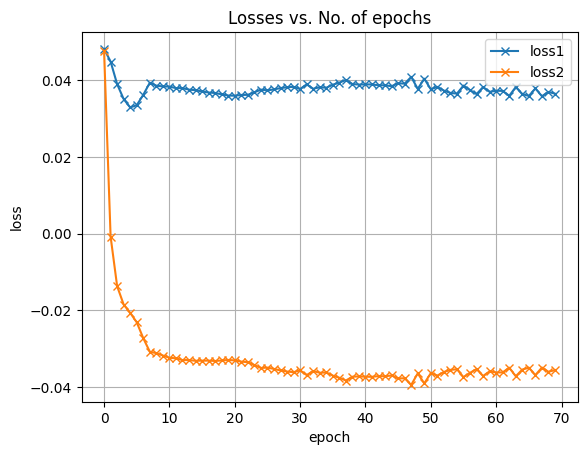

In [ ]:
plot_history(history)


## **Save the model**

In [ ]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model_SWaT.pth")

In [ ]:
filename = 'usad_SWaT.sav'
pickle.dump(model, open(filename, 'wb'))

In [23]:
checkpoint = torch.load("model_SWaT.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [43]:
training_scores_list=training_scores(model,train_loader,val_loader)

In [44]:
training_scores_concat=np.concatenate([torch.stack(training_scores_list[:-1]).flatten().detach().cpu().numpy(),
                            training_scores_list[-1].flatten().detach().cpu().numpy()])

In [46]:
print(training_scores_concat)
min(training_scores_concat)

[0.30965337 0.3096711  0.30968213 ... 0.01092041 0.01092516 0.01086419]


0.009538653

In [47]:
results=training_scores(model, test_loader) # testing


In [48]:
print(results)


[tensor([0.0458, 0.0458, 0.0458,  ..., 0.0424, 0.0424, 0.0423],
       grad_fn=<AddBackward0>), tensor([0.0424, 0.0425, 0.0425,  ..., 0.0448, 0.0448, 0.0448],
       grad_fn=<AddBackward0>), tensor([0.0447, 0.0447, 0.0447,  ..., 0.1024, 0.1024, 0.1024],
       grad_fn=<AddBackward0>), tensor([0.1024, 0.1024, 0.1025,  ..., 0.0414, 0.0414, 0.0413],
       grad_fn=<AddBackward0>), tensor([0.0413, 0.0413, 0.0414,  ..., 0.0823, 0.0794, 0.0766],
       grad_fn=<AddBackward0>), tensor([0.0735, 0.0697, 0.0652,  ..., 0.3341, 0.3341, 0.3341],
       grad_fn=<AddBackward0>), tensor([0.3341, 0.3341, 0.3341,  ..., 0.0922, 0.0888, 0.0853],
       grad_fn=<AddBackward0>), tensor([0.0818, 0.0792, 0.0770,  ..., 0.0455, 0.0455, 0.0455],
       grad_fn=<AddBackward0>), tensor([0.0456, 0.0456, 0.0455,  ..., 0.0480, 0.0480, 0.0480],
       grad_fn=<AddBackward0>), tensor([0.0480, 0.0480, 0.0479,  ..., 0.1023, 0.1023, 0.1023],
       grad_fn=<AddBackward0>), tensor([0.1023, 0.1023, 0.1022,  ..., 0.0493, 0.0

In [49]:
windows_labels=[]
for i in range(len(labels_down)-window_size):
    windows_labels.append(list(np.int_(labels_down[i:i+window_size])))

In [50]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels]

In [51]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                            results[-1].flatten().detach().cpu().numpy()])

In [56]:
results_threshold=testing_threshold(model,test_loader,alpha=.5, beta=.5, contamination=0.10)

In [57]:
results_threshold

0.12279378

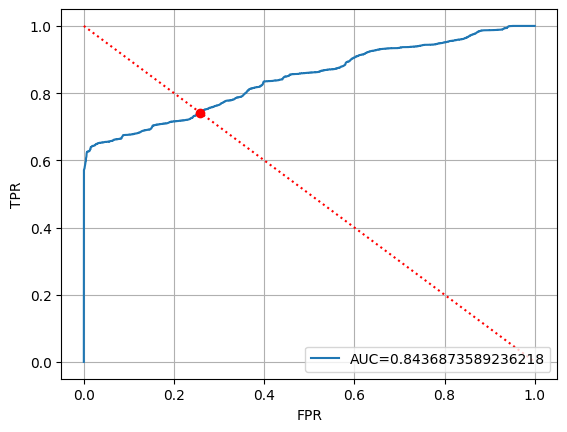

array([0.0869233], dtype=float32)

In [58]:
threshold=ROC(y_test,y_pred)
threshold

In [59]:
threshold=results_threshold
y_pred_label = [1.0 if (score > threshold) else 0 for score in y_pred ]

In [60]:
prec=precision_score(y_test,y_pred_label,pos_label=1)
recall=recall_score(y_test,y_pred_label,pos_label=1)
f1=f1_score(y_test,y_pred_label,pos_label=1)
print('precision=',prec)
print('recall=',recall)
print('f1=',f1)

precision= 0.810381238190508
recall= 0.6433992234380516
f1= 0.7173004082837326
